In [1]:
import numpy as np
from matplotlib import pyplot as plt
from tifffile import imread
from skimage.filters import threshold_multiotsu
import os
import porespy as ps
from tifffile import imwrite
from hydra.experimental import compose, initialize
from lpu3dnet.inference import block_generation_singlecond as block_generation

from omegaconf import OmegaConf
import torch
from matplotlib import pyplot as plt
from tifffile import imread
import numpy as np
import pickle
from hydra.experimental import compose, initialize
import os
import torch
from lpu3dnet.frame import vqgan
from lpu3dnet.frame import transformer

def clean_img(img_t):
    '''
    2  3^3 median image filter
    3 Otsu binary segmentation
    https://homepages.inf.ed.ac.uk/rbf/HIPR2/median.htm
    https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_multiotsu.html
    '''

    thresholds = threshold_multiotsu(img_t,classes=2)
    # from the threshold we separate regions
    img_t = np.digitize(img_t, bins=thresholds)

    return img_t


def img_crop(img,crop_size):
    x_max = img.shape[0]
    y_max = img.shape[1]
    z_max = img.shape[2]

    sec = img[
        crop_size:x_max-crop_size,
        crop_size:y_max-crop_size,
        crop_size:z_max-crop_size
        ]
    return sec


def np_to_tif(img,f_name):
    '''
    convert numpy to tif
    '''

    img_save = (img * 255).astype('uint8')
    # Save the 3D array as a 3D tif
    imwrite(f_name, img_save)

def tif_to_np(f_name):
    '''
    convert tif to numpy
    '''
    img = imread(f_name)
    img = img.astype('float32')/255
    return img>0.5

def visualize_planes_grid_single(img_arr):
    """
    Visualizes 2D slices from a single 3D image in a 3x6 grid.
    
    Parameters:
    img_arr (numpy.ndarray): A 3D numpy array with shape (196, 196, 196).
    """
    # Define the slice indices for visualization
    slice_indices = [20, 50, 80, 110, 140, 170]

    # Create a 3x6 grid for visualization
    fig, axs = plt.subplots(3, 6, figsize=(18, 9))

    for i in range(3):  # Three different planes
        for j in range(6):  # Six different slices
            slice_index = slice_indices[j]

            # Determine the plane and slice to display
            if i == 0:  # XY plane evolution
                slice_2d = img_arr[:, :, slice_index]
                title = f'XY plane at Z={slice_index}'
            elif i == 1:  # XZ plane evolution
                slice_2d = img_arr[:, slice_index, :]
                title = f'XZ plane at Y={slice_index}'
            else:  # YZ plane evolution
                slice_2d = img_arr[slice_index, :, :]
                title = f'YZ plane at X={slice_index}'

            # Display the 2D slice
            axs[i, j].imshow(slice_2d, cmap='gray')
            axs[i, j].set_title(title, fontsize=8)
            axs[i, j].axis('off')

    plt.tight_layout()
    plt.show()
from cpgan.ooppnm import img_process
img_prc = img_process.Image_process()


initialize(config_path=f"../config/ex12")
cfg_vqgan = compose(config_name="vqgan")
cfg_transformer = compose(config_name="transformer")
cfg_dataset = compose(config_name="dataset")

/journel/s0/zur74/venv/pnm-old/lib/python3.9/site-packages/hydra/experimental/initialize.py:43: UserWarning: hydra.experimental.initialize() is no longer experimental. Use hydra.initialize()
  deprecation_warning(message=message)
/journel/s0/zur74/venv/pnm-old/lib/python3.9/site-packages/hydra/experimental/initialize.py:45: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  self.delegate = real_initialize(
/journel/s0/zur74/venv/pnm-old/lib/python3.9/site-packages/hydra/experimental/compose.py:25: UserWarning: hydra.experimental.compose() is no longer experimental. Use hydra.compose()
  deprecation_warning(message=message)


In [36]:
img_list = []
for i in range(6):
    img_list.append(
        tif_to_np(
            os.path.join(
                cfg_dataset.PATH.main_vol,
                f'main_{i}.tif'
                )
                  )
        )

img_idx = 1
volume_dimension = 5
img_sample = img_list[img_idx]
img_sample = img_sample[:volume_dimension*64,
                        :volume_dimension*64,
                        :volume_dimension*64]



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

block_generator = block_generation.Block_generator_compare(
    cfg_dataset,
    cfg_vqgan,
    cfg_transformer,
    epoch_vqgan=25,
    epoch_transformer=50,
    device = device,
    img=img_sample,
    volume_dimension=volume_dimension
    )

block_generator.generate_block(repeat=4)

The shape of comparing image is (320, 320, 320)
number of parameters: 183.73M


In [37]:
import numpy as np

def get_volume_shape(ds_spatial):
    max_i, max_j, max_k = 0, 0, 0
    for ijk in ds_spatial.keys():
        i, j, k = ijk
        max_i = max(max_i, i)
        max_j = max(max_j, j)
        max_k = max(max_k, k)
    return max_i + 1, max_j + 1, max_k + 1

def assemble_volume(ds_spatial):
    volume_shape = get_volume_shape(ds_spatial)
    volume = np.zeros((volume_shape[0] * 64, volume_shape[1] * 64, volume_shape[2] * 64))
    volume_original = np.zeros((volume_shape[0] * 64, volume_shape[1] * 64, volume_shape[2] * 64))

    for ijk, data in ds_spatial.items():
        i, j, k = ijk
        image = data['img']
        image_original = data['img_original']
        volume[i*64:(i+1)*64, j*64:(j+1)*64, k*64:(k+1)*64] = image
        volume_original[i*64:(i+1)*64, j*64:(j+1)*64, k*64:(k+1)*64] = image_original

    return volume,volume_original

volume,volume_original = assemble_volume(block_generator.ds_spatial)

print(img_prc.phi(volume),img_prc.phi(volume_original))

0.19319644165039063 0.18978851318359374


Original:


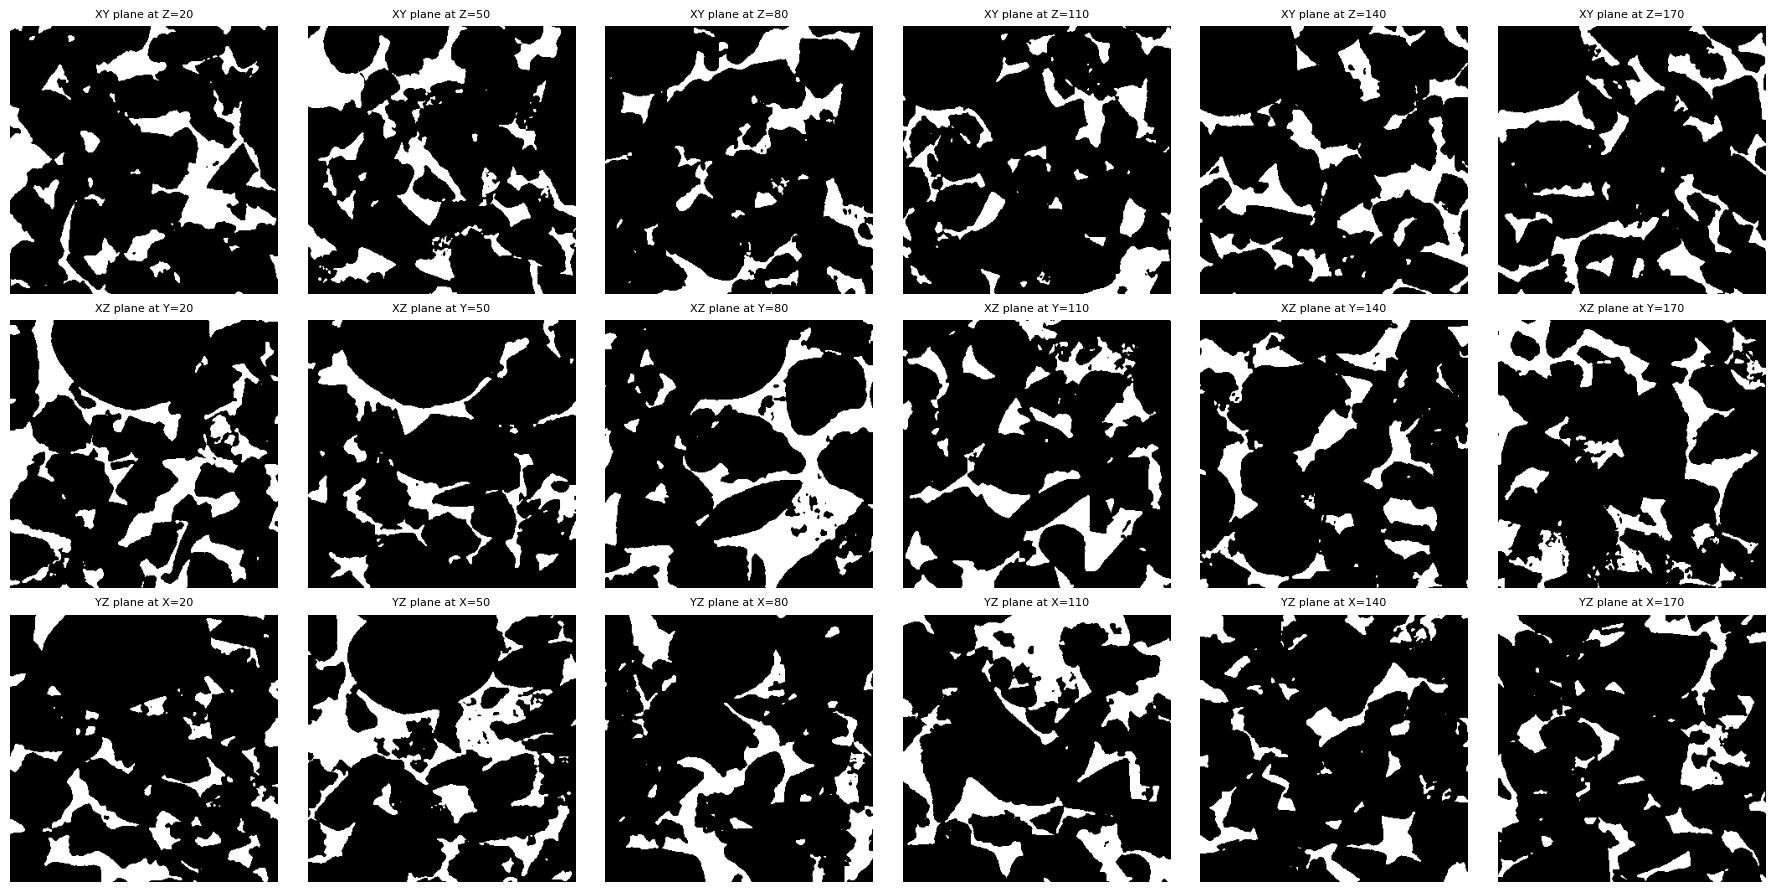

Generated:


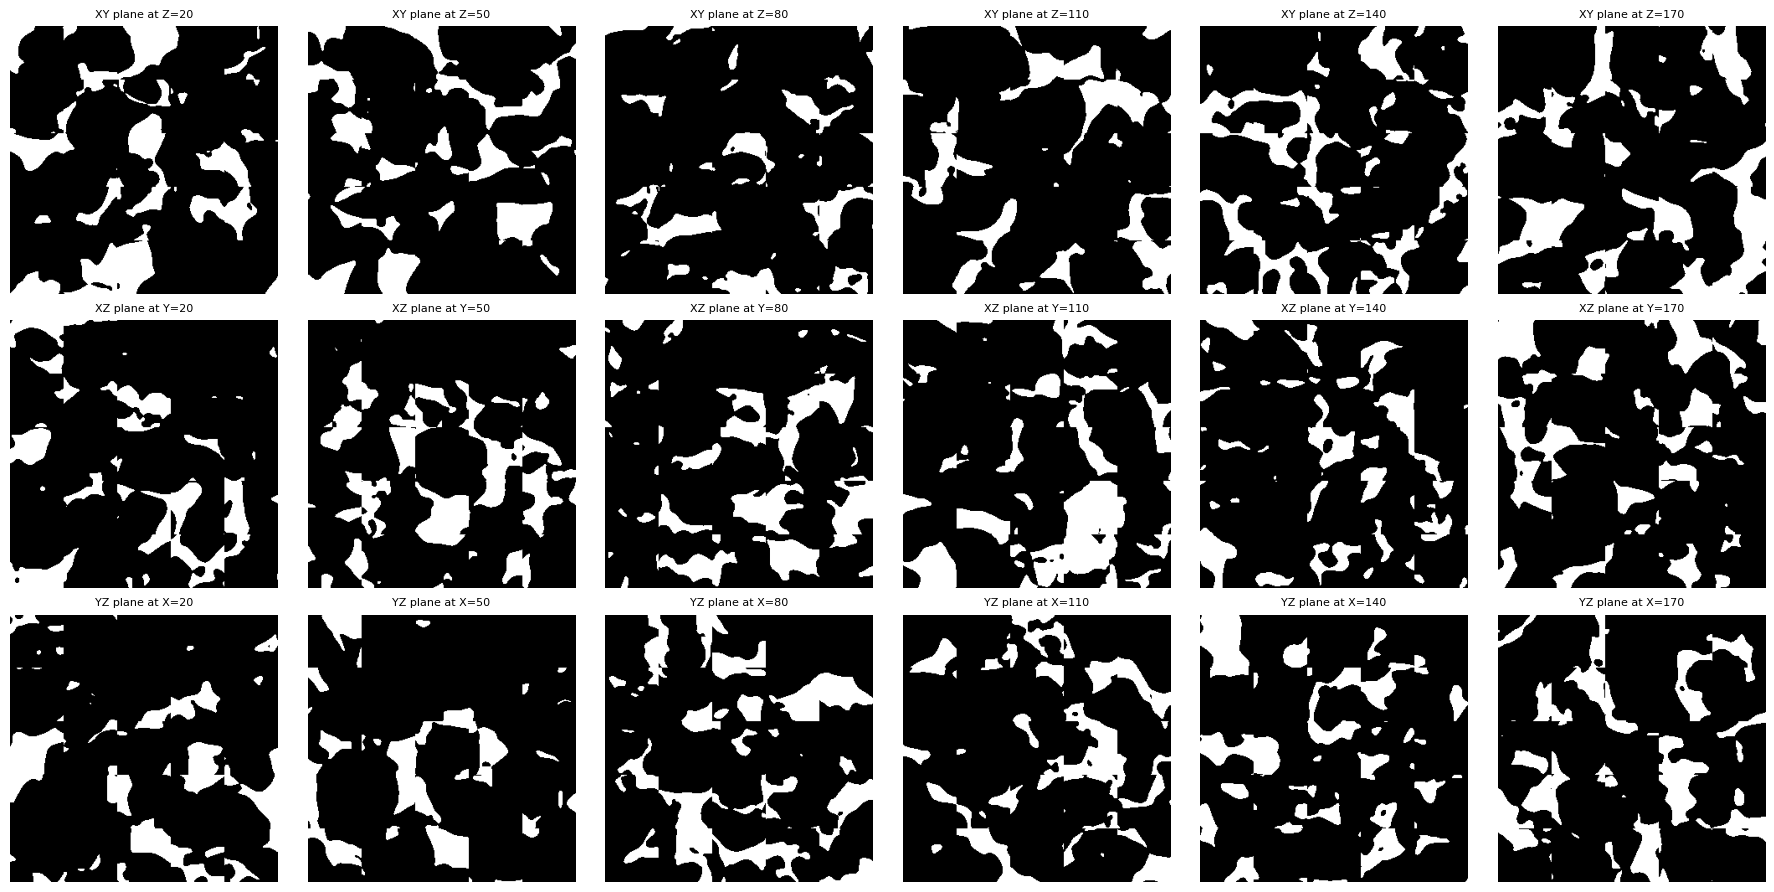

In [38]:
print("Original:")
visualize_planes_grid_single(volume_original)

print("Generated:")
visualize_planes_grid_single(volume)


#### Read existing data

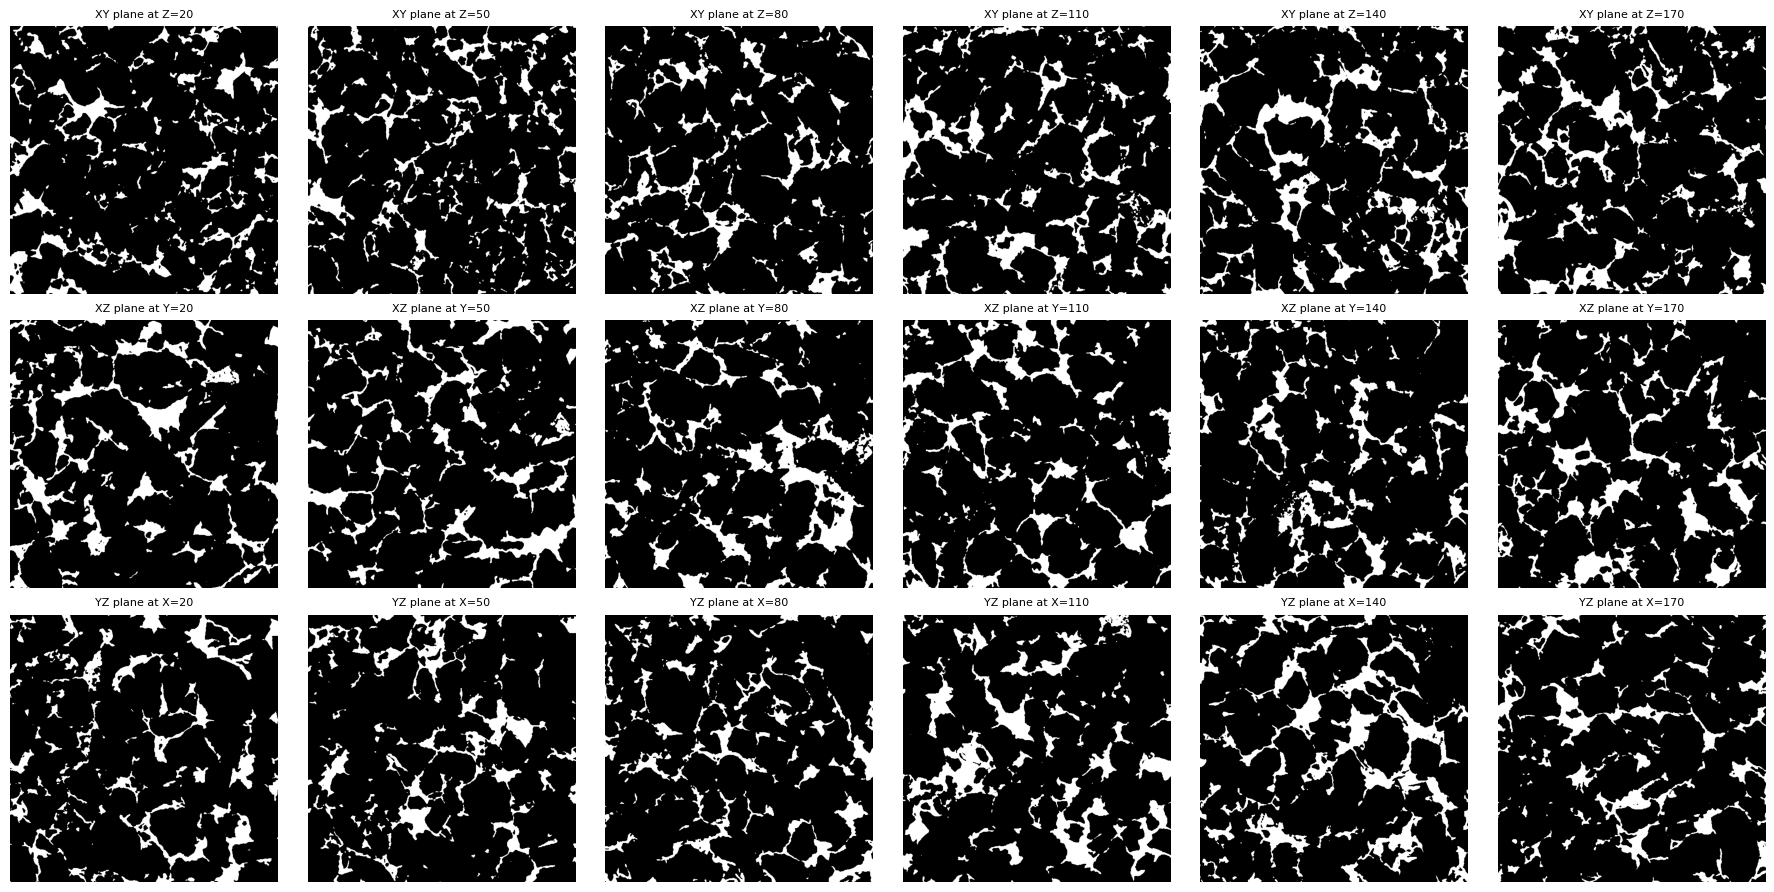

Compare:


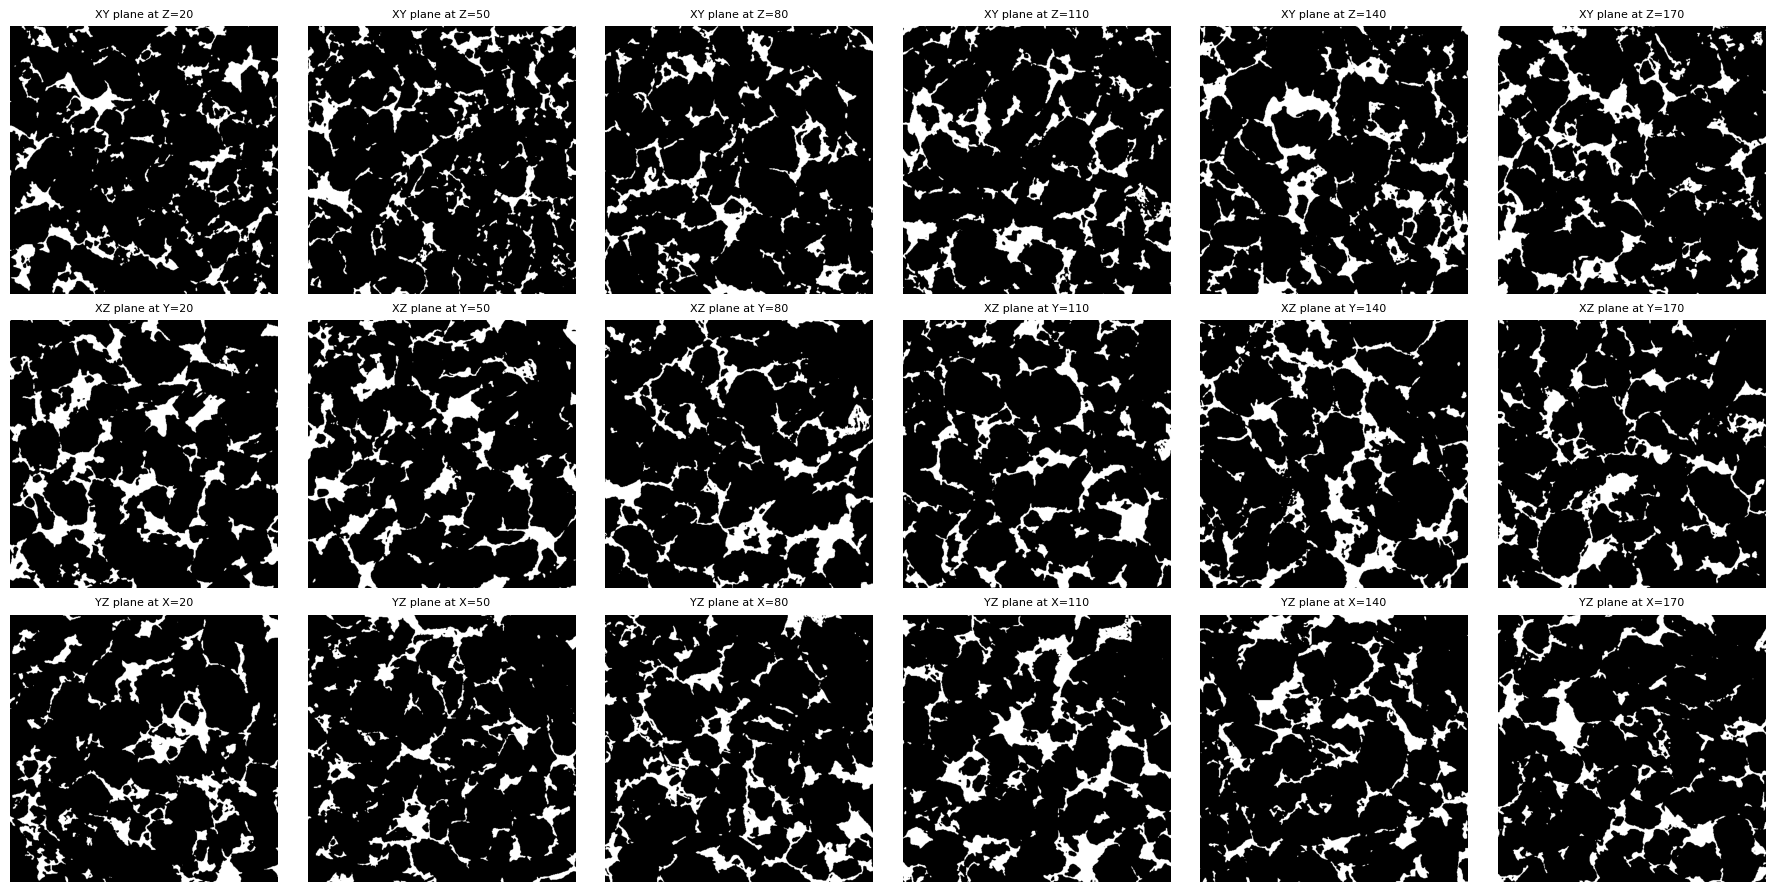

In [10]:
# read pickle file fiven ct and vol_dim
def load_data(ct_idx, vol_dim, root_dir):
    file_path = f'{root_dir}/sample_{ct_idx}/img_gen_vol_{vol_dim}.pkl'
    with open(file_path, 'rb') as file:
        img_results = pickle.load(file)
    return img_results

# gloabl variables
volume_dim = 9
root_dir = '../post_process/db'
img_data = load_data(0, volume_dim, root_dir)

sample_idx = 0
img_origin = img_data[sample_idx]['original']
visualize_planes_grid_single(img_origin)

print("Compare:")


img_compare = img_data['compare'] 
visualize_planes_grid_single(img_compare[2])


In [8]:
img_data['compare']

[array([[[ True, False,  True, ..., False, False, False],
         [ True,  True,  True, ..., False, False, False],
         [ True,  True, False, ..., False, False, False],
         ...,
         [ True,  True,  True, ..., False, False, False],
         [ True,  True,  True, ..., False, False, False],
         [ True,  True,  True, ..., False, False, False]],
 
        [[ True,  True,  True, ..., False, False, False],
         [ True,  True,  True, ..., False, False, False],
         [ True,  True,  True, ..., False, False, False],
         ...,
         [ True,  True,  True, ..., False, False, False],
         [ True,  True,  True, ..., False, False, False],
         [ True,  True,  True, ..., False, False, False]],
 
        [[ True,  True,  True, ..., False, False, False],
         [ True,  True,  True, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [ True,  True,  True, ..., False, False, False],
         [ True,  True, 